In [1]:
#import os
import sys
sys.path.append("../python/")
from helpers import *

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns


In [129]:
SENSITIVITY_RESULTS_DIR = '../../results/sensitivity-tests'
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]

In [78]:
fmri = sns.load_dataset("fmri") 

In [32]:
dt = json.load(open(res[0]))
dt2 = json.load(open(res[1]))

In [50]:
d1 = pd.DataFrame(dt["metrics"])
d2 = pd.DataFrame(dt2["metrics"])
d1['epoch'] = d1.index + 1
d2['epoch'] = d2.index + 1
d1["trial"] = 0
d2["trial"] = 1

In [53]:
d = pd.DataFrame()

In [54]:
d = d.append(d1, ignore_index=True)

In [55]:
d = d.append(d2, ignore_index=True)
len(d)

20

In [139]:
def getPerformanceDataFrame():
    result_file_list = getListOfFiles(SENSITIVITY_RESULTS_DIR)
    df = pd.DataFrame()
    for filename in result_file_list:
        if "scenario_resolution_" in filename:
            performance_dict = json.load(open(filename))
            performance_df = pd.DataFrame(performance_dict["metrics"])
            performance_df['epoch'] = performance_df.index + 1
            performance_df["resolution"] = performance_dict["image_size"]
            performance_df["scenario"] = performance_dict["scenario"]
            performance_df["best_val_accuracy"] = performance_dict["best_val_accuracy"]
            performance_df["trial"] = int(filename.split("_")[-1].split(".")[0])
            df = df.append(performance_df, ignore_index=True)
    return(df)

In [140]:
df1 = getPerformanceDataFrame()

In [141]:
df1.head()

,loss,accuracy,val_loss,val_accuracy,epoch,resolution,scenario,best_val_accuracy,trial
0,0.476019,0.788119,0.513502,0.788119,1,64,Pr_PoIm,0.924752,3
1,0.210119,0.942079,0.479386,0.788119,2,64,Pr_PoIm,0.924752,3
2,0.101560,0.975248,0.538900,0.788119,3,64,Pr_PoIm,0.924752,3
3,0.071955,0.981188,0.592937,0.788119,4,64,Pr_PoIm,0.924752,3
4,0.039395,0.991089,0.643306,0.788119,5,64,Pr_PoIm,0.924752,3


In [153]:
dfm = df1.melt(id_vars = ["epoch", "resolution", "scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"],var_name = "metric", value_name = "value")

In [154]:
dfm["type"] = None

In [155]:
dfm.loc[dfm.metric.isin(["loss", "val_loss"]),"type"] = "Loss"
dfm.loc[dfm.metric.isin(["accuracy", "val_accuracy"]),"type"] = "Accuracy"

In [156]:
dfm.scenario.unique()

array(['Pr_PoIm', 'PrPo_Im', 'Pr_Im'], dtype=object)

In [ ]:
g1 = sns.FacetGrid(df1, col)

<AxesSubplot:xlabel='epoch', ylabel='value'>

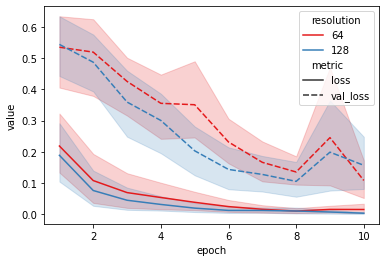

In [111]:
sns.lineplot(x = "epoch", y = "value", style = "metric", hue = "resolution", data = dfml, palette= sns.color_palette("Set1", n_colors=2))

In [121]:
def plotMeanAccuracyLoss_Defunct(scenario_list):
    num_scenarios = len(scenario_list)
    fig, axes = plt.subplots(2, num_scenarios, figsize=(12, 10), sharex = True)
    fig.suptitle("Scenario: " + scenario)
    scenario_count = 0
    for scenario in scenario_list:
        df = getScenarioDataFrame(scenario)
        melted_df = df.melt(id_vars = ["epoch", "resolution", "scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
        melted_df_loss = melted_df[melted_df.metric.isin(["loss", "val_loss"])]
        melted_df_acc = melted_df[melted_df.metric.isin(["accuracy", "val_accuracy"])]
        sns.lineplot(ax = axes[0, scenario_count], x = "epoch", y = "value", style = "metric", hue = "resolution", data = melted_df_acc, palette= sns.color_palette("Set1", n_colors=2))
        sns.lineplot(ax = axes[1, scenario_count], x = "epoch", y = "value", style = "metric", hue = "resolution", data = melted_df_loss, palette= sns.color_palette("Set1", n_colors=2))    
        if scenario_count == 0:
            axes[0, scenario_count].set_ytitle("Accuracy")
            axes[1, scenario_count].set_xtitle("Loss")   
        scenario_count += 1
    axes[0].legend()
    return()

In [311]:
def plotMeanAccuracyLoss():
    df = getPerformanceDataFrame()
    melted_df = df.melt(id_vars = ["epoch", "resolution", "scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy"]), "type"] = "Accuracy"
    
    num_scenarios = len(df.scenario.unique())
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", row="type", sharey = False)
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric", hue = "resolution", palette= sns.color_palette("Set1", n_colors=2) )
    g.set_axis_labels("Epoch", "")
    g.add_legend() #title = ["Resolution", "Metric"])
    #g.fig.legends[0].set_title("Resolution")
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 1)#.75
                axes[row, col].set_title(str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0])
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss")
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0.5, 1)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Accuracy")
    g.savefig("../../figures/scenario_resolution_performance.png", dpi=180)
    return(g)

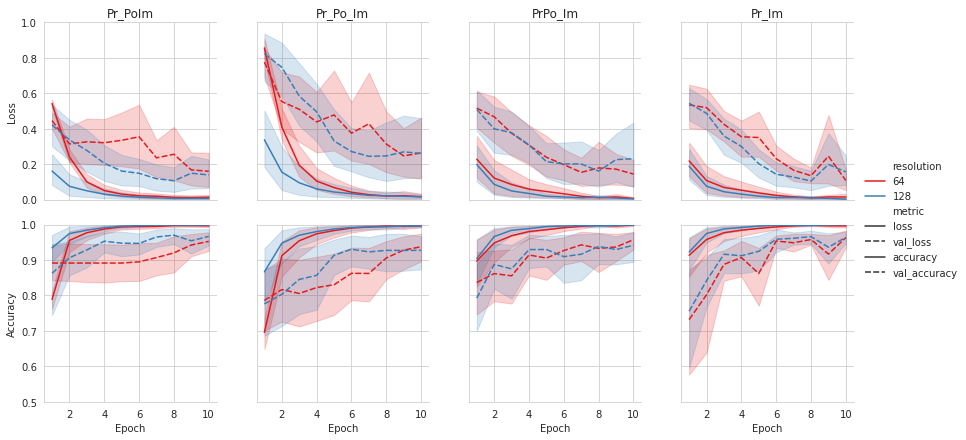

In [312]:
#plotMeanAccuracyLoss("Pr_Im")
gg = plotMeanAccuracyLoss()

In [244]:
str(gg.axes[0,1].title).split("scenario = ")[1].split(")")[0].split("\'")[0]

'Pr_Po_Im'

In [219]:
for r in enumerate(gg.axes[0]):
    print(r)

(0, <AxesSubplot:title={'center':'type = Loss | scenario = Pr_PoIm'}>)
(1, <AxesSubplot:title={'center':'type = Loss | scenario = PrPo_Im'}>)
(2, <AxesSubplot:title={'center':'type = Loss | scenario = Pr_Im'}>)


In [285]:
#gg.fig.legends[0].labels

AttributeError: 'Legend' object has no attribute 'labels'

In [298]:
#gg.fig.legend().get_legend_handler_map()[tuple]